In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import csr_matrix
%matplotlib inline

In [34]:
wiki = pd.DataFrame.from_csv('people_wiki.csv')
wiki = wiki.reset_index()

In [35]:
wiki.head()

,URI,name,text
0,<http://dbpedia.org/resource/Digby_Morrell>,Digby Morrell,digby morrell born 10 october 1979 is a former...
1,<http://dbpedia.org/resource/Alfred_J._Lewy>,Alfred J. Lewy,alfred j lewy aka sandy lewy graduated from un...
2,<http://dbpedia.org/resource/Harpdog_Brown>,Harpdog Brown,harpdog brown is a singer and harmonica player...
3,<http://dbpedia.org/resource/Franz_Rottensteiner>,Franz Rottensteiner,franz rottensteiner born in waidmannsfeld lowe...
4,<http://dbpedia.org/resource/G-Enka>,G-Enka,henry krvits born 30 december 1974 in tallinn ...


In [36]:
def load_sparse_csr(filename):
    loader = np.load(filename)
    data = loader['data']
    indices = loader['indices']
    indptr = loader['indptr']
    shape = loader['shape']
    
    return csr_matrix((data, indices, indptr), shape)

In [37]:
word_count = load_sparse_csr('people_wiki_word_count.npz')

In [240]:
map_index_to_word = pd.read_json('people_wiki_map_index_to_word.json', typ='series', orient='records')
word_map = {v: k for k, v in map_index_to_word.to_dict().items()}

In [39]:
from sklearn.neighbors import NearestNeighbors

model = NearestNeighbors(metric='euclidean', algorithm='brute')
model.fit(word_count)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [40]:
wiki[wiki['name'] == 'Barack Obama']

,URI,name,text
35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...


In [41]:
wiki.loc[35817]

URI            <http://dbpedia.org/resource/Barack_Obama>
name                                         Barack Obama
text    barack hussein obama ii brk husen bm born augu...
Name: 35817, dtype: object

In [42]:
distances, indices = model.kneighbors(word_count[35817], n_neighbors=10)

In [43]:
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})

In [44]:
wiki['id'] = wiki.index.values.tolist()

In [54]:
pd.merge(neighbors, wiki, on='id').sort_values(by=['distance'])

,distance,id,URI,name,text
0,0.000000,35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...
1,33.075671,24478,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...
2,34.394767,28447,<http://dbpedia.org/resource/George_W._Bush>,George W. Bush,george walker bush born july 6 1946 is an amer...
3,36.152455,35357,<http://dbpedia.org/resource/Lawrence_Summers>,Lawrence Summers,lawrence henry larry summers born november 30 ...
4,36.166283,14754,<http://dbpedia.org/resource/Mitt_Romney>,Mitt Romney,willard mitt romney born march 12 1947 is an a...
5,36.331804,13229,<http://dbpedia.org/resource/Francisco_Barrio>,Francisco Barrio,francisco javier barrio terrazas born november...
6,36.400549,31423,<http://dbpedia.org/resource/Walter_Mondale>,Walter Mondale,walter frederick fritz mondale born january 5 ...
7,36.496575,22745,<http://dbpedia.org/resource/Wynn_Normington_H...,Wynn Normington Hugh-Jones,sir wynn normington hughjones kb sometimes kno...
8,36.633318,36364,<http://dbpedia.org/resource/Don_Bonker>,Don Bonker,don leroy bonker born march 7 1937 in denver c...
9,36.959437,9210,<http://dbpedia.org/resource/Andy_Anstett>,Andy Anstett,andrue john andy anstett born june 25 1946 is ...


Check Franciso Barrio and Obama

In [60]:
def unpack_dict(matrix, map_index_to_word):
    table = sorted(map_index_to_word, key=map_index_to_word.get)
    
    
    data = matrix.data
    indices = matrix.indices
    indptr = matrix.indptr
    
    num_doc = matrix.shape[0]

    return [{k:v for k,v in zip([table[word_id] for word_id in indices[indptr[i]:indptr[i+1]] ],
                                 data[indptr[i]:indptr[i+1]].tolist())} \
               for i in range(num_doc) ]

wiki['word_count'] = unpack_dict(word_count, map_index_to_word)

In [134]:
def top_words(name):
    """
    Get a table of the most frequent words in the given person's wikipedia page.
    """
    row = wiki[wiki['name'] == name]
    counts = [(k, v) for k,v in row['word_count'].values[0].items()]
    word_count_table = pd.DataFrame(counts, columns=['word', 'count'])
    return word_count_table.sort_values('count', ascending=False)

obama_words = top_words('Barack Obama')
print(obama_words.head())

barrio_words = top_words('Francisco Barrio')
print(barrio_words.head())

       word  count
224  487987     40
30   251998     30
14    58956     21
214  360177     18
92   494272     14
       word  count
20   487987     36
176  360177     24
29    58956     18
35   251998     17
162  233866     10


In [135]:
combined_words = pd.merge(obama_words, barrio_words, on='word')

In [138]:
combined_words = combined_words.rename(columns={'count_x': 'Obama', 'count_y': 'Barrio'})

In [152]:
common_words = combined_words.sort_values('Obama', ascending=False)[:5]['word'].values.tolist()

In [161]:
def has_top_words(word_count_vector):
    unique_words = set(word_count_vector.keys())
    if all(word in unique_words for word in common_words):
        return True
    return False

wiki['has_top_words'] = wiki['word_count'].apply(has_top_words)

In [167]:
print('Output from your function:', has_top_words(wiki.loc[32]['word_count']))
print('Correct output: True')

print ('Also check the length of unique_words. It should be 167')
print ('Output from your function:', has_top_words(wiki.loc[33]['word_count']))
print ('Correct output: False')
print ('Also check the length of unique_words. It should be 188')

Output from your function: True
Correct output: True
Also check the length of unique_words. It should be 167
Output from your function: False
Correct output: False
Also check the length of unique_words. It should be 188


Quiz Question. Among the words that appear in both Barack Obama and Francisco Barrio, 
take the 5 that appear most frequently in Obama. How many of the articles in the Wikipedia 
dataset contain all of those 5 words?

In [173]:
wiki['has_top_words'].sum()

56066

Quiz Question. Measure the pairwise distance between the Wikipedia pages of Barack Obama, 
George W. Bush, and Joe Biden. Which of the three pairs has the smallest distance?

In [205]:
obama = word_count[wiki[wiki['name'] == 'Barack Obama'].id.values]
bush = word_count[wiki[wiki['name'] == 'George W. Bush'].id.values]
biden = word_count[wiki[wiki['name'] == 'Joe Biden'].id.values]

assert not hasattr(obama, 'name')

obama.name = 'obama'
bush.name = 'bush'
biden.name = 'biden'

In [206]:
from sklearn.metrics.pairwise import euclidean_distances
from itertools import combinations

In [207]:
for x, y in combinations([obama, bush, biden], 2):
    print('Euclidean distance between {} and {} is: {}'.format(x.name, y.name, euclidean_distances(x, y)))

Euclidean distance between obama and bush is: [[ 34.39476704]]
Euclidean distance between obama and biden is: [[ 33.07567082]]
Euclidean distance between bush and biden is: [[ 32.75667871]]


Quiz Question. Collect all words that appear both in Barack Obama and George W. Bush pages. Out of those words, find the 10 words that show up most often in Obama's page.

In [208]:
obama_words = top_words('Barack Obama')
bush_words = top_words('George W. Bush')

In [210]:
obama_and_bush = pd.merge(obama_words, bush_words, on='word')

In [212]:
obama_and_bush = obama_and_bush.rename(columns={'count_x': 'Obama', 'count_y': 'Bush'})

In [214]:
obama_and_bush.sort_values('Obama', ascending=False)[:10]

,word,Obama,Bush
0,487987,40,39
1,251998,30,22
2,58956,21,14
3,360177,18,14
4,494272,14,11
5,239363,11,6
6,45121,8,3
7,233866,7,8
8,41740,7,6
9,292612,6,1


# TF-IDF

In [215]:
tf_idf = load_sparse_csr('people_wiki_tf_idf.npz')

In [216]:
wiki['tf_idf'] = unpack_dict(tf_idf, map_index_to_word)

In [217]:
model_tf_idf = NearestNeighbors(metric='euclidean', algorithm='brute')
model_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='euclidean',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [218]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=10)

In [219]:
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})

In [221]:
tf_combined_df = pd.merge(neighbors, wiki, on='id')

In [222]:
tf_combined_df

,distance,id,URI,name,text,word_count,has_top_words,tf_idf
0,0.000000,35817,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,"{365034: 1, 367621: 1, 418994: 1, 534330: 1, 3...",True,"{365034: 1.9128915408224825, 367621: 1.4424007..."
1,106.861014,7914,<http://dbpedia.org/resource/Phil_Schiliro>,Phil Schiliro,phil schiliro is an american political consult...,"{126721: 1, 414763: 1, 292612: 3, 23813: 1, 12...",True,"{126721: 4.497290457899877, 414763: 6.55567859..."
2,108.871674,46811,<http://dbpedia.org/resource/Jeff_Sessions>,Jeff Sessions,jefferson beauregard jeff sessions iii born de...,"{239363: 1, 136456: 1, 19721: 1, 41740: 3, 362...",True,"{239363: 0.2626114552136573, 136456: 4.1621217..."
3,109.045698,44681,<http://dbpedia.org/resource/Jesse_Lee_(politi...,Jesse Lee (politician),jesse lee born 1979 was named the white house ...,"{498987: 1, 23813: 1, 368903: 1, 19721: 1, 358...",True,"{498987: 4.721194176487485, 23813: 1.564436483..."
4,109.108106,38376,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,"{16899: 1, 56839: 1, 462344: 1, 70674: 1, 2393...",True,"{16899: 2.0687826320938068, 56839: 3.977086456..."
5,109.781867,6507,<http://dbpedia.org/resource/Bob_Menendez>,Bob Menendez,robert bob menendez born january 1 1954 is the...,"{208128: 1, 462344: 1, 55818: 1, 125783: 2, 41...",True,"{208128: 3.003055326218652, 462344: 2.70224359..."
6,109.957788,38714,<http://dbpedia.org/resource/Eric_Stern_(polit...,Eric Stern (politician),eric stern is the director of operations for t...,"{396545: 1, 107523: 2, 292612: 8, 368903: 1, 3...",True,"{396545: 5.402999080443495, 107523: 4.69133927..."
7,110.413889,44825,<http://dbpedia.org/resource/James_A._Guest>,James A. Guest,james alfred guest is an american lawyer and c...,"{16899: 1, 292612: 1, 48903: 2, 211884: 1, 417...",True,"{16899: 2.0687826320938068, 292612: 2.45382262..."
8,110.470609,44368,<http://dbpedia.org/resource/Roland_Grossenbac...,Roland Grossenbacher,dr roland edouard grossenbacher is a swiss att...,"{382208: 1, 239363: 2, 292612: 3, 23813: 3, 29...",True,"{382208: 2.5603215961961254, 239363: 0.5252229..."
9,110.696998,33417,<http://dbpedia.org/resource/Tulsi_Gabbard>,Tulsi Gabbard,tulsi gabbard born april 12 1981 is an america...,"{156928: 1, 511232: 1, 23813: 1, 48903: 2, 431...",True,"{156928: 6.6170475367581725, 511232: 5.6346372..."


In [254]:
def top_words_tf_idf(name):
    row = wiki[wiki['name'] == name]
    weights = [(k, v) for k,v in row['tf_idf'].values[0].items()]
    word_weight_table = pd.DataFrame(weights, columns=['word', 'weight'])
    return word_weight_table.sort_values('weight', ascending=False)

obama_tf_idf = top_words_tf_idf('Barack Obama')
print (obama_tf_idf[:10])

schiliro_tf_idf = top_words_tf_idf('Phil Schiliro')
print (schiliro_tf_idf[:10])

       word     weight
129  358666  43.295653
37    45121  27.678223
115  259313  17.747379
205  138643  14.887061
125  292612  14.722936
256  365546  14.533374
154  328679  13.115933
139  417924  12.784385
95   258758  12.784385
174  155998  12.410689
       word     weight
39   435776  21.972991
118  465407  15.856442
10   136718  13.547088
63   151158  10.986495
6    358666   9.621256
76   526231   9.040585
93   395711   9.033587
47    27405   8.683910
2    292612   7.361468
37   137787   6.913104


In [255]:
tf_obama_and_schiliro = pd.merge(obama_tf_idf, schiliro_tf_idf, on='word')

In [261]:
tf_obama_and_schiliro = tf_obama_and_schiliro.rename(columns={'weight_x': 'Obama', 'weight_y': 'Schiliro'})

In [264]:
tf_obama_and_schiliro.sort_values('Obama', ascending=False)[:10]

,word,Obama,Schiliro
0,358666,43.295653,9.621256
1,292612,14.722936,7.361468
2,155998,12.410689,6.205344
3,442714,10.164288,3.388096
4,395774,7.386955,3.693478
5,395711,7.226869,9.033587
6,389713,6.095386,3.047693
7,466930,5.473201,1.824400
8,360399,5.248173,2.624086
9,25336,5.107041,3.404694


Quiz Question. Among the words that appear in both Barack Obama and Phil Schiliro, take the 5 that have largest weights in Obama. How many of the articles in the Wikipedia dataset contain all of those 5 words?

In [268]:
common_words = tf_obama_and_schiliro.sort_values('Obama', ascending=False)['word'][:5]

In [269]:
def has_top_words(word_count_vector):
    unique_words = set(word_count_vector.keys())
    if all(word in unique_words for word in common_words):
        return True
    return False

wiki['tf_has_top_words'] = wiki['word_count'].apply(has_top_words)

In [270]:
wiki['tf_has_top_words'].sum()

14

Quiz Question. Compute the Euclidean distance between TF-IDF features of Obama and Biden.

In [271]:
obama = tf_idf[wiki[wiki['name'] == 'Barack Obama'].id.values]
biden = tf_idf[wiki[wiki['name'] == 'Joe Biden'].id.values]

assert not hasattr(obama, 'name')

obama.name = 'obama'
biden.name = 'biden'

In [272]:
euclidean_distances(obama, biden)

array([[ 123.29745601]])

In [275]:
def compute_length(row):
    return len(row['text'].split(' '))
wiki['length'] = wiki.apply(compute_length, axis=1)

In [277]:
distances, indices = model_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)

In [278]:
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})

In [279]:
nearest_neighbors_euclidean = pd.merge(wiki, neighbors, on='id')

In [282]:
nearest_neighbors_euclidean.sort_values('distance')

,URI,name,text,id,word_count,has_top_words,tf_idf,tf_has_top_words,length,distance
58,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,35817,"{365034: 1, 367621: 1, 418994: 1, 534330: 1, 3...",True,"{365034: 1.9128915408224825, 367621: 1.4424007...",True,540,0.000000
18,<http://dbpedia.org/resource/Phil_Schiliro>,Phil Schiliro,phil schiliro is an american political consult...,7914,"{126721: 1, 414763: 1, 292612: 3, 23813: 1, 12...",True,"{126721: 4.497290457899877, 414763: 6.55567859...",True,208,106.861014
79,<http://dbpedia.org/resource/Jeff_Sessions>,Jeff Sessions,jefferson beauregard jeff sessions iii born de...,46811,"{239363: 1, 136456: 1, 19721: 1, 41740: 3, 362...",True,"{239363: 0.2626114552136573, 136456: 4.1621217...",False,230,108.871674
76,<http://dbpedia.org/resource/Jesse_Lee_(politi...,Jesse Lee (politician),jesse lee born 1979 was named the white house ...,44681,"{498987: 1, 23813: 1, 368903: 1, 19721: 1, 358...",True,"{498987: 4.721194176487485, 23813: 1.564436483...",False,216,109.045698
63,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,38376,"{16899: 1, 56839: 1, 462344: 1, 70674: 1, 2393...",True,"{16899: 2.0687826320938068, 56839: 3.977086456...",False,310,109.108106
8,<http://dbpedia.org/resource/Bob_Menendez>,Bob Menendez,robert bob menendez born january 1 1954 is the...,6507,"{208128: 1, 462344: 1, 55818: 1, 125783: 2, 41...",True,"{208128: 3.003055326218652, 462344: 2.70224359...",False,220,109.781867
65,<http://dbpedia.org/resource/Eric_Stern_(polit...,Eric Stern (politician),eric stern is the director of operations for t...,38714,"{396545: 1, 107523: 2, 292612: 8, 368903: 1, 3...",True,"{396545: 5.402999080443495, 107523: 4.69133927...",False,255,109.957788
77,<http://dbpedia.org/resource/James_A._Guest>,James A. Guest,james alfred guest is an american lawyer and c...,44825,"{16899: 1, 292612: 1, 48903: 2, 211884: 1, 417...",True,"{16899: 2.0687826320938068, 292612: 2.45382262...",False,215,110.413889
75,<http://dbpedia.org/resource/Roland_Grossenbac...,Roland Grossenbacher,dr roland edouard grossenbacher is a swiss att...,44368,"{382208: 1, 239363: 2, 292612: 3, 23813: 3, 29...",True,"{382208: 2.5603215961961254, 239363: 0.5252229...",False,201,110.470609
54,<http://dbpedia.org/resource/Tulsi_Gabbard>,Tulsi Gabbard,tulsi gabbard born april 12 1981 is an america...,33417,"{156928: 1, 511232: 1, 23813: 1, 48903: 2, 431...",True,"{156928: 6.6170475367581725, 511232: 5.6346372...",False,228,110.696998


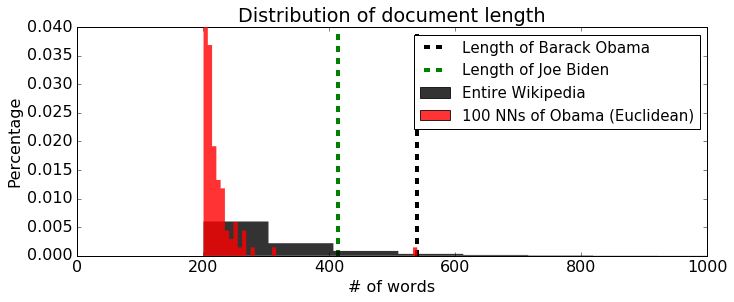

In [289]:
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].values[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].values[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])

plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size':16})
plt.tight_layout()

# Cosine distance

In [290]:
model2_tf_idf = NearestNeighbors(algorithm='brute', metric='cosine')
model2_tf_idf.fit(tf_idf)

NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=1, n_neighbors=5, p=2, radius=1.0)

In [291]:
distances, indices = model2_tf_idf.kneighbors(tf_idf[35817], n_neighbors=100)

In [293]:
neighbors = pd.DataFrame({'distance': distances.flatten(), 'id': indices.flatten()})

In [295]:
nearest_neighbors_cosine = pd.merge(wiki, neighbors, on='id')

In [298]:
nearest_neighbors_cosine.sort_values('distance', ascending=True)

,URI,name,text,id,word_count,has_top_words,tf_idf,tf_has_top_words,length,distance
59,<http://dbpedia.org/resource/Barack_Obama>,Barack Obama,barack hussein obama ii brk husen bm born augu...,35817,"{365034: 1, 367621: 1, 418994: 1, 534330: 1, 3...",True,"{365034: 1.9128915408224825, 367621: 1.4424007...",True,540,-1.110223e-15
45,<http://dbpedia.org/resource/Joe_Biden>,Joe Biden,joseph robinette joe biden jr dosf rbnt badn b...,24478,"{226817: 1, 89090: 8, 423939: 2, 528608: 1, 43...",True,"{226817: 4.963047796264162, 89090: 63.92610492...",True,414,7.031387e-01
65,<http://dbpedia.org/resource/Samantha_Power>,Samantha Power,samantha power born september 21 1970 is an ir...,38376,"{16899: 1, 56839: 1, 462344: 1, 70674: 1, 2393...",True,"{16899: 2.0687826320938068, 56839: 3.977086456...",False,310,7.429819e-01
98,<http://dbpedia.org/resource/Hillary_Rodham_Cl...,Hillary Rodham Clinton,hillary diane rodham clinton hlri dan rdm klnt...,57108,"{18679: 3, 423939: 1, 349701: 1, 270344: 1, 44...",True,"{18679: 5.784074899761413, 423939: 2.203559032...",True,580,7.583584e-01
67,<http://dbpedia.org/resource/Eric_Stern_(polit...,Eric Stern (politician),eric stern is the director of operations for t...,38714,"{396545: 1, 107523: 2, 292612: 8, 368903: 1, 3...",True,"{396545: 5.402999080443495, 107523: 4.69133927...",False,255,7.705612e-01
79,<http://dbpedia.org/resource/Robert_Gibbs>,Robert Gibbs,robert lane gibbs born march 29 1971 is an ame...,46140,"{536321: 1, 423939: 1, 487987: 17, 23813: 1, 3...",True,"{536321: 2.136551161989598, 423939: 2.20355903...",False,257,7.846775e-01
15,<http://dbpedia.org/resource/Eric_Holder>,Eric Holder,eric himpton holder jr born january 21 1951 is...,6796,"{536321: 1, 425474: 1, 423939: 1, 292612: 1, 1...",True,"{536321: 2.136551161989598, 425474: 9.60020102...",False,232,7.880391e-01
77,<http://dbpedia.org/resource/Jesse_Lee_(politi...,Jesse Lee (politician),jesse lee born 1979 was named the white house ...,44681,"{498987: 1, 23813: 1, 368903: 1, 19721: 1, 358...",True,"{498987: 4.721194176487485, 23813: 1.564436483...",False,216,7.909264e-01
36,<http://dbpedia.org/resource/Henry_Waxman>,Henry Waxman,henry arnold waxman born september 12 1939 is ...,18827,"{456705: 1, 304386: 1, 254211: 1, 23813: 3, 53...",True,"{456705: 6.361522575940923, 304386: 2.57377421...",False,279,7.983226e-01
3,<http://dbpedia.org/resource/Joe_the_Plumber>,Joe the Plumber,samuel joseph wurzelbacher wrzlbkr born decemb...,2412,"{314626: 1, 239363: 1, 228481: 1, 153608: 1, 3...",True,"{314626: 8.042056410058754, 239363: 0.26261145...",False,217,7.994664e-01


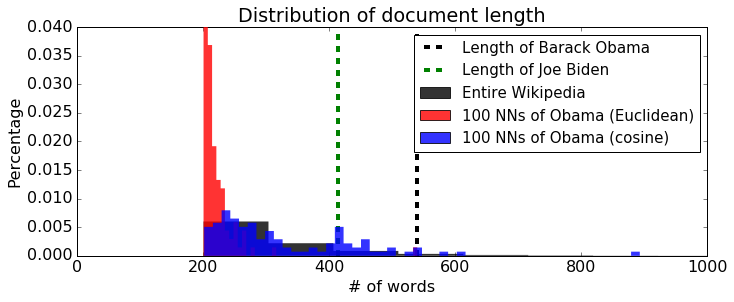

In [300]:
plt.figure(figsize=(10.5,4.5))
plt.figure(figsize=(10.5,4.5))
plt.hist(wiki['length'], 50, color='k', edgecolor='None', histtype='stepfilled', normed=True,
         label='Entire Wikipedia', zorder=3, alpha=0.8)
plt.hist(nearest_neighbors_euclidean['length'], 50, color='r', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (Euclidean)', zorder=10, alpha=0.8)
plt.hist(nearest_neighbors_cosine['length'], 50, color='b', edgecolor='None', histtype='stepfilled', normed=True,
         label='100 NNs of Obama (cosine)', zorder=11, alpha=0.8)
plt.axvline(x=wiki['length'][wiki['name'] == 'Barack Obama'].values[0], color='k', linestyle='--', linewidth=4,
           label='Length of Barack Obama', zorder=2)
plt.axvline(x=wiki['length'][wiki['name'] == 'Joe Biden'].values[0], color='g', linestyle='--', linewidth=4,
           label='Length of Joe Biden', zorder=1)
plt.axis([0, 1000, 0, 0.04])
plt.legend(loc='best', prop={'size':15})
plt.title('Distribution of document length')
plt.xlabel('# of words')
plt.ylabel('Percentage')
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

In [301]:
tweet = {'act': 3.4597778278724887,
 'control': 3.721765211295327,
 'democratic': 3.1026721743330414,
 'governments': 4.167571323949673,
 'in': 0.0009654063501214492,
 'law': 2.4538226269605703,
 'popular': 2.764478952022998,
 'response': 4.261461747058352,
 'to': 0.04694493768179923}